In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
from PIL import Image
# loading in and transforming data
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

%matplotlib inline

In [3]:
base_path = "../input/gan-getting-started/"
monet_path = base_path + 'monet_jpg'
monet_folder = os.listdir(monet_path)
photo_path = base_path + 'photo_jpg'
photo_folder = os.listdir(photo_path)
print(len(monet_folder),len(photo_folder))

300 7038


In [4]:
from glob import glob
monet_Patches = glob('../input/gan-getting-started/monet_jpg/*.jpg', recursive=True)
photo_Patches = glob('../input/gan-getting-started/photo_jpg/*.jpg', recursive=True)
print(len(monet_Patches),len(photo_Patches)) # total no. of images

300 7038


In [5]:
monet_df = pd.DataFrame()
monet_df["images"] = monet_Patches
monet_df = monet_df.reset_index(drop=True)
monet_df.head()

,images
0,../input/gan-getting-started/monet_jpg/8840229...
1,../input/gan-getting-started/monet_jpg/8558021...
2,../input/gan-getting-started/monet_jpg/14ff6e6...
3,../input/gan-getting-started/monet_jpg/51bdd25...
4,../input/gan-getting-started/monet_jpg/e9f5563...


In [6]:
photo_df = pd.DataFrame()
photo_df["images"] = photo_Patches
photo_df = photo_df.reset_index(drop=True)
photo_df.head()

,images
0,../input/gan-getting-started/photo_jpg/eacb6ea...
1,../input/gan-getting-started/photo_jpg/94e066f...
2,../input/gan-getting-started/photo_jpg/54538ae...
3,../input/gan-getting-started/photo_jpg/ce15456...
4,../input/gan-getting-started/photo_jpg/38c88ad...


In [7]:
from sklearn.model_selection import train_test_split
# spliting the dataset into train test and validation parts
train_monet , test_monet = train_test_split(monet_df,test_size=0.33)
train_photo , test_photo = train_test_split(photo_df,test_size=0.33)

print(len(train_monet),len(test_monet),len(train_photo),len(test_photo))

201 99 4715 2323


In [8]:
import cv2

In [9]:
class Transformed_dataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        temp = self.df
        temp = np.squeeze(temp)
        img_path = temp[index]
        #print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256,256))
        if self.transform is not None:
            image = self.transform(image)
        return image

In [10]:
# Data preprocessing
#transforms.RandomHorizontalFlip(), 
#transforms.RandomVerticalFlip(),
#transforms.RandomRotation(20),

trans_train = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train_X = Transformed_dataset(df_data=train_monet, transform=trans_train)
dataset_valid_X = Transformed_dataset(df_data=test_monet,transform=trans_valid)
dataset_train_Y = Transformed_dataset(df_data=train_photo,transform=trans_train)
dataset_valid_Y = Transformed_dataset(df_data=test_photo,transform=trans_valid)

In [11]:
loader_train_X = DataLoader(dataset = dataset_train_X, batch_size=32, shuffle=True, num_workers=0)
loader_valid_X = DataLoader(dataset = dataset_valid_X, batch_size=32, shuffle=False, num_workers=0)
loader_train_Y = DataLoader(dataset = dataset_train_Y, batch_size=32, shuffle=True, num_workers=0)
loader_valid_Y = DataLoader(dataset = dataset_valid_Y, batch_size=32, shuffle=False, num_workers=0)

In [12]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [13]:
def show_dataloader(loader):   
    # obtain one batch of training images
    dataiter = iter(loader)
    images = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images[idx])

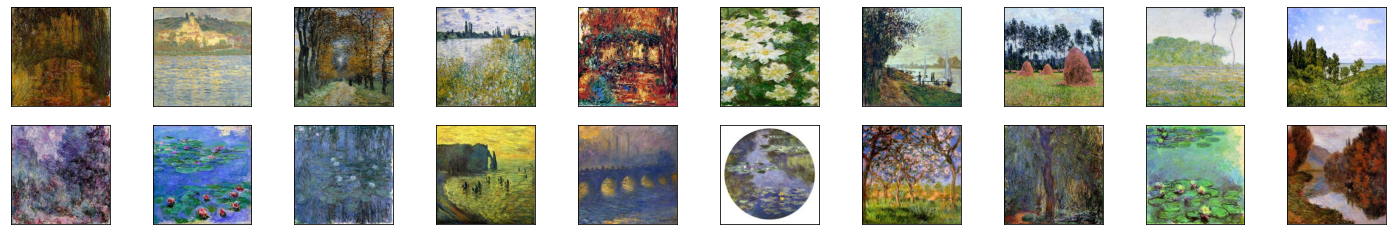

In [14]:
#images of monet from dataloader X
show_dataloader(loader_train_X)

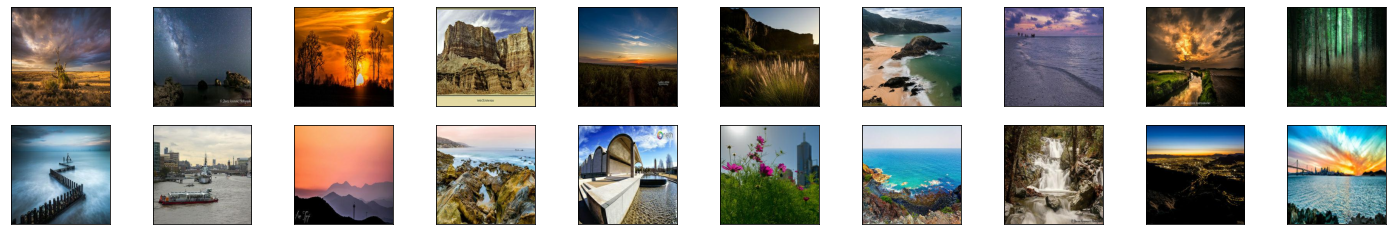

In [15]:
#images of photos from dataloader Y
show_dataloader(loader_train_Y)

In [16]:
# current range
dataiter = iter(loader_train_X)
images = dataiter.next()
images = images.numpy()
img = images

print('Min: ', img.min())
print('Max: ', img.max())

Min:  -1.0
Max:  1.0


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [18]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4,batch_norm=True)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4,batch_norm=True)
        self.conv4 = conv(conv_dim*4,conv_dim*8,4,batch_norm=True)
        self.conv5 = conv(conv_dim*8,1,4,stride=1,batch_norm=False)
        
    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        
        return x

In [19]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim,conv_dim,3,stride=1,batch_norm=True)
        self.conv2 = conv(conv_dim,conv_dim,3,stride=1,batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out = F.relu(self.conv1(x))
        out_2 = x + F.relu(self.conv2(out))
        
        return out_2
    

In [20]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [21]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # 2. Define the resnet part of the generator
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

In [22]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim,n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim,n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [23]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [24]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache
print("total mem {}".format(t))
print("cached mem {}".format(c))
print("alloc mem {}".format(a))
print("free mem {}".format(f))

total mem 17071734784
cached mem 109051904
alloc mem 89702400
free mem 19349504


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [25]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

In [26]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)
    

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean((D_out)**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss


In [27]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999 

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [28]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

#scipy imports
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='./'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='./samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))


In [29]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()
    fixed_Y = test_iter_Y.next()

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X = iter_X.next()
        images_Y = iter_Y.next()
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()
        # 1. Compute the discriminator losses on real images
        d_x_real_loss = real_mse_loss(D_X(images_X))
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_x = G_YtoX(images_Y)
        # 3. Compute the fake loss for D_X
        d_x_fake_loss = fake_mse_loss(fake_x)
        # 4. Compute the total loss and perform backprop
        d_x_loss = d_x_real_loss + d_x_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        d_y_real_loss = real_mse_loss(D_Y(images_Y))
        fake_y = G_XtoY(images_X)
        d_y_fake_loss = fake_mse_loss(fake_y)
        
        d_y_loss = d_y_real_loss + d_y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()
        


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_x = G_YtoX(images_Y)
        
        # 2. Compute the generator loss based on domain X
        gen_Y_X_loss = real_mse_loss(D_X(fake_x))
        
        # 3. Create a reconstructed y
        recons_y = G_XtoY(fake_x)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        recons_loss_y = cycle_consistency_loss(images_Y,recons_y, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        
        fake_y = G_XtoY(images_X)
        gen_X_Y_loss = real_mse_loss(D_Y(fake_y))
        recons_x = G_YtoX(fake_y)
        recons_loss_x = cycle_consistency_loss(images_X,recons_x, lambda_weight=10)

        
        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = gen_Y_X_loss + gen_X_Y_loss + recons_loss_y + recons_loss_x
        
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        """ sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=32)
            G_YtoX.train()
            G_XtoY.train()"""

        # uncomment these lines, if you want to save your model
        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [ ]:
n_epochs = 3000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(loader_train_X,loader_train_Y,loader_valid_X,loader_valid_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.1379 | d_Y_loss: 0.2270 | g_total_loss: 3.1191
Epoch [   20/ 5000] | d_X_loss: 0.1350 | d_Y_loss: 0.2464 | g_total_loss: 3.0716
Epoch [   30/ 5000] | d_X_loss: 0.1577 | d_Y_loss: 0.2123 | g_total_loss: 4.1618
Epoch [   40/ 5000] | d_X_loss: 0.1469 | d_Y_loss: 0.2372 | g_total_loss: 3.6921
Epoch [   50/ 5000] | d_X_loss: 0.1240 | d_Y_loss: 0.2249 | g_total_loss: 3.2141
Epoch [   60/ 5000] | d_X_loss: 0.1524 | d_Y_loss: 0.1814 | g_total_loss: 3.0938
Epoch [   70/ 5000] | d_X_loss: 0.1210 | d_Y_loss: 0.1768 | g_total_loss: 3.2846
Epoch [   80/ 5000] | d_X_loss: 0.1323 | d_Y_loss: 0.2115 | g_total_loss: 3.0178
Epoch [   90/ 5000] | d_X_loss: 0.1204 | d_Y_loss: 0.2110 | g_total_loss: 3.1927
Epoch [  100/ 5000] | d_X_loss: 0.1233 | d_Y_loss: 0.2008 | g_total_loss: 3.0004
Epoch [  110/ 5000] | d_X_loss: 0.1273 | d_Y_loss: 0.1850 | g_total_loss: 3.0493
Epoch [  120/ 5000] | d_X_loss: 0.1233 | d_Y_loss: 0.1958 | g_total_loss: 2.9016
Epoch [  130/ 5000] | d_X_lo

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


In [ ]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')